Here we are importing the libraries we will be using in the project and we are importing the train and test files. 

In [30]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

training_data=pd.read_csv('./train.csv')
test_data=pd.read_csv('./test.csv')

This is a sample of the data stored in the train dataset file.

In [2]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This is a sample of the data stored in the test dataset file. It doesn't contain the survived column as this is the value we are going to predict.

In [3]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


This function shows the info of the train dataset indicating how many non-null values exist. 

In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


This function shows the info of the test dataset indicating how many non-null values exist. 

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


This is a function we define to help visualize the data. 
We will compare survivors vs. dead numbers depending on several features.

In [6]:
def hist(feature):
    survivors = training_data[training_data['Survived']==1][feature].value_counts()
    dead = training_data[training_data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survivors,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

This histogram represents the number of survivors and dead from each passenger class.

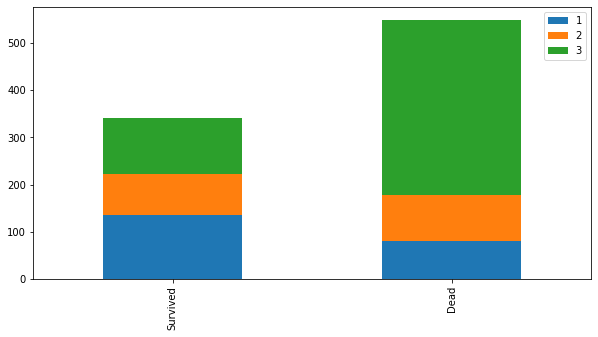

In [7]:
hist('Pclass')

We notice that passengers of the first class are more likely to survive and passengers from the third class are more likely to die. 

This histogram represents the number of survivors and dead from each sex.

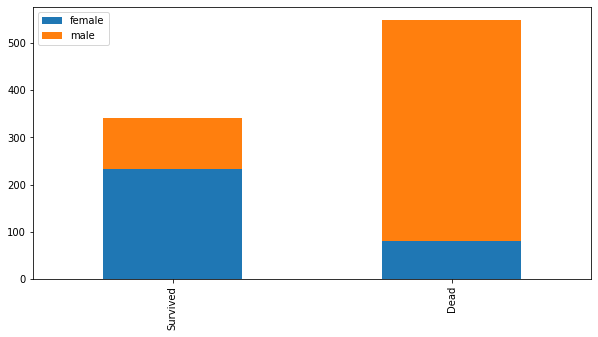

In [8]:
hist('Sex')

We notice that female passengers are more likely to survive and male passengers are more likely to die. 

This histogram represents the number of survivors and dead based on either the passenger had a sibling or spouse on board.

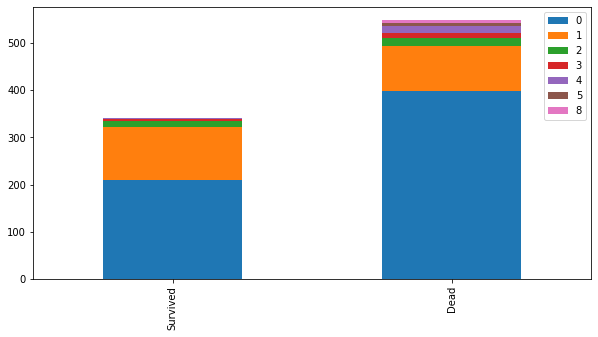

In [9]:
hist('SibSp')

We notice that passengers who are boarding alone are more likely to die. 

We will delete the name feature from the dataset as it is not a necessary feature.

In [10]:
training_data.drop(['Name'], axis=1, inplace=True)
test_data.drop(['Name'], axis=1, inplace=True)
training_data.drop(['Embarked'], axis=1, inplace=True)
test_data.drop(['Embarked'], axis=1, inplace=True)

In [11]:
training_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN
3,4,1,1,female,35.0,1,0,113803,53.1000,C123
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN


In [12]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
0,892,3,male,34.5,0,0,330911,7.8292,NaN
1,893,3,female,47.0,1,0,363272,7.0000,NaN
2,894,2,male,62.0,0,0,240276,9.6875,NaN
3,895,3,male,27.0,0,0,315154,8.6625,NaN
4,896,3,female,22.0,1,1,3101298,12.2875,NaN


We will combine the training and testing dataset into one dataset for when we need to perform operations on both of them at the same time.

In [14]:
train_test_data = [training_data, test_data]

We will change the values assigned to sex into numeric values to be easier for machine learning. 

In [15]:
sexMapping={"female":1, "male":0}
for dataset in train_test_data:
    dataset['Sex']=dataset['Sex'].map(sexMapping)

The values male and female are now 0 and 1.

The feature age has some missing data so we will try to fill them out using median.

In [16]:
median=training_data["Age"].median()
training_data["Age"].fillna(median,inplace=True)
test_data["Age"].fillna(median,inplace=True)

We will fill the missing values in fare with the average of the price of the according class.

In [17]:
training_data["Fare"].fillna(training_data.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test_data["Fare"].fillna(test_data.groupby("Pclass")["Fare"].transform("median"), inplace=True)

Since we noticed that first class passengers are more likely to survive than third class, we will try to recognize which cabins are first class and which cabins are first class. 

In [18]:
training_data.Cabin.value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
F33            3
C22 C26        3
              ..
C106           1
B39            1
D6             1
E17            1
D15            1
Name: Cabin, Length: 147, dtype: int64

In [19]:
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

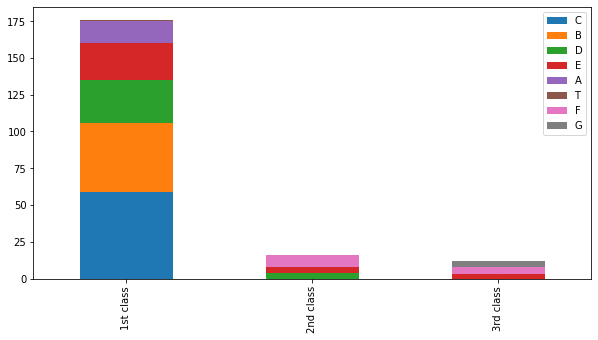

In [20]:
Pclass1 = training_data[training_data['Pclass']==1]['Cabin'].value_counts()
Pclass2 = training_data[training_data['Pclass']==2]['Cabin'].value_counts()
Pclass3 = training_data[training_data['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

We notice that first class has most of the A B C D cabins. 
Second and third class don't have the A B C cabins.

We will fill the missing cabin values with the median of each class. 
But first we need to assign numeric values to cabins in order to get the median.

In [21]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

In [22]:
training_data["Cabin"].fillna(training_data.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test_data["Cabin"].fillna(test_data.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

The ticket number is not an informative feature so we will drop it.

In [23]:
training_data.drop('Ticket', axis=1, inplace=True)
test_data.drop('Ticket', axis=1, inplace=True)

In [24]:
training_data.head(30)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,1,0,3,0,22.0,1,0,7.2500,2.0
1,2,1,1,1,38.0,1,0,71.2833,0.8
2,3,1,3,1,26.0,0,0,7.9250,2.0
3,4,1,1,1,35.0,1,0,53.1000,0.8
4,5,0,3,0,35.0,0,0,8.0500,2.0
5,6,0,3,0,28.0,0,0,8.4583,2.0
6,7,0,1,0,54.0,0,0,51.8625,1.6
7,8,0,3,0,2.0,3,1,21.0750,2.0
8,9,1,3,1,27.0,0,2,11.1333,2.0
9,10,1,2,1,14.0,1,0,30.0708,1.8


Now we have all the features with numeric values.

We will start the model cross validation using random forest.

In [25]:
train_data = training_data.drop('Survived', axis=1)
target = training_data['Survived']

train_data.shape, target.shape

((891, 8), (891,))

In [26]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [38]:
clf = DecisionTreeClassifier()
clf.fit(train_data, target)

prediction = clf.predict(test_data)

ValueError: ignored

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": prediction
    })

submission.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()